# 风险平价组合

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xlsxwriter
from scipy.optimize import minimize, basinhopping
import empyrical
%matplotlib inline

In [65]:
DATA_DIR = '../data/'
TOLERANCE = 1e-10

In [66]:
def metric(daily_ret):
    an_ret = empyrical.annual_return(daily_ret)
    sharpe = empyrical.sharpe_ratio(daily_ret)
    vol = empyrical.annual_volatility(daily_ret)
    maxdraw = empyrical.max_drawdown(daily_ret)
    print('Annual return: %.2f%%'%(an_ret*100))
    print('Sharpe ratio: %.2f'%(sharpe))
    print('Annual volatility: %.2f%%'%(vol*100))
    print('Max drawdown: %.2f%%'%(maxdraw*100))

# 读取数据

In [67]:
fname = '%s/assets.xlsx'%(DATA_DIR)
odf = pd.read_excel(fname, index_col=0)

In [68]:
odf.tail()

,881001.WI,HSI.HI,SPX.GI,CBA00101.CS,AU9999.SGE,B.IPE,H11025.CSI,CCFI.WI,CBA00401.CS,CBA02701.CS,000300.SH,000906.SH
2018-11-01,3359.2869,25416.00,2740.37,184.5338,274.85,72.75,1502.9764,1139.2211,181.7677,172.1626,3177.0338,3358.4891
2018-11-02,3468.1867,26486.35,2723.06,184.4406,274.34,72.62,1503.0974,1140.1038,181.5316,172.1548,3290.2455,3475.5765
2018-11-05,3462.2941,25934.39,2738.31,184.5189,275.52,72.71,1503.4507,1148.2160,181.6435,172.2024,3262.8351,3453.8770
2018-11-06,3450.4874,26120.96,2755.45,184.6294,274.86,71.65,1503.5717,1149.1610,181.8166,172.2458,3243.1504,3437.4196
2018-11-07,3433.2097,26147.69,2755.45,184.7824,275.22,72.00,1503.5717,1140.9266,182.0688,172.3143,3221.9101,3416.0185


# 标准风险平价

In [69]:
def _allocation_risk(weights, covariances):
    
    # calculate the risk of the weights distribution
    portfolio_risk = np.sqrt((weights * covariances * weights.T))[0, 0]
    
    # It returns the risk of the weights distribution
    return portfolio_risk

In [70]:
def _assets_risk_contribution_to_allocation_risk(weights, covariances):
    
    # calculate the risk of the weights distribution
    portfolio_risk = _allocation_risk(weights, covariances)
    
    # calculate the contribution of each asset to the risk of the weights distribution
    assets_risk_contribution = np.multiply(weights.T, covariances * weights.T) / portfolio_risk
    
    # It returns the contribution of each asset to the risk of the weights distribution
    return assets_risk_contribution

In [71]:
def _risk_budget_objective_error(weights, args):

    # The covariance matrix occupies the first position in the variable
    covariances = args[0]

    # The desired contribution of each asset to the portfolio risk occupies the second position
    assets_risk_budget = args[1]

    # We convert the weights to a matrix
    weights = np.matrix(weights)

    # We calculate the risk of the weights distribution
    portfolio_risk = _allocation_risk(weights, covariances)

    # We calculate the contribution of each asset to the risk of the weights distribution
    assets_risk_contribution = _assets_risk_contribution_to_allocation_risk(weights, covariances)

    # We calculate the desired contribution of each asset to the risk of the weights distribution
    assets_risk_target = np.asmatrix(np.multiply(portfolio_risk, assets_risk_budget))

    # Error between the desired contribution and the calculated contribution of each asset
    error = sum(np.square(assets_risk_contribution - assets_risk_target.T))[0, 0]

    # It returns the calculated error
    return error

In [72]:
def _get_risk_parity_weights(covariances, assets_risk_budget, initial_weights):
    # Restrictions to consider in the optimisation: only long positions whose
    # sum equals 100%
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0},
                   {'type': 'ineq', 'fun': lambda x: x})
    # Optimisation process in scipy
    optimize_result = minimize(fun=_risk_budget_objective_error,
                               x0=initial_weights,
                               args=[covariances, assets_risk_budget],
                               method='SLSQP',
                               constraints=constraints,
                               tol=TOLERANCE,
                               options={'disp': False})
    # Recover the weights from the optimised object
    weights = optimize_result.x

    # It returns the optimised weights
    return weights

# 用样本协方差计算风险平价组合权重

In [73]:
df = odf[['000300.SH', '000906.SH', 'HSI.HI', 'SPX.GI', 'CBA00101.CS', 'AU9999.SGE']]

In [74]:
df = df.replace([0], np.NAN)

In [75]:
ret_df = df.pct_change().dropna()

### 过去一年协方差

In [76]:
covariances = ret_df.iloc[-242:].cov()

In [77]:
empyrical.annual_volatility(ret_df['SPX.GI'])

0.18942387921686987

### 计算权重

In [78]:
n = df.shape[1]
init_weights = np.array([1. / n] * n)
assets_risk_budget = np.array([1./12, 1./12, 1./12, 1./12, 1./3, 1./3])
# assets_risk_budget = np.array([1. / n] * n)

In [79]:
assets_risk_budget

array([0.08333333, 0.08333333, 0.08333333, 0.08333333, 0.33333333,
       0.33333333])

### 等权下的风险贡献

In [80]:
rc = _assets_risk_contribution_to_allocation_risk(np.matrix(init_weights), covariances.values)

In [81]:
rc

matrix([[ 2.09056847e-03],
        [ 2.05719416e-03],
        [ 1.75472128e-03],
        [ 5.76402548e-04],
        [-1.82105501e-05],
        [ 4.55059264e-05]])

### 风险权重相等

In [82]:
weights = _get_risk_parity_weights(covariances.values*1e6, assets_risk_budget, init_weights)

In [83]:
weights

array([0.01297622, 0.01358547, 0.01529618, 0.02679051, 0.8024282 ,
       0.12892341])

In [84]:
rc = _assets_risk_contribution_to_allocation_risk(np.matrix(weights), covariances.values)

In [85]:
rc

matrix([[7.73102078e-05],
        [7.73086050e-05],
        [7.73105302e-05],
        [7.73061300e-05],
        [3.09240780e-04],
        [3.09238816e-04]])

In [86]:
abs((rc / rc.sum() - assets_risk_budget).sum()) < TOLERANCE

True

# 回测

In [87]:
new_df = df[(df.index >= ret_df.index[0]) & (df.index <= ret_df.index[-1])]

In [88]:
new_df.head()

,000300.SH,000906.SH,HSI.HI,SPX.GI,CBA00101.CS,AU9999.SGE
2005-01-05,992.564,995.576,13764.36,1183.74,105.9273,114.64
2005-01-06,983.174,986.216,13712.04,1187.89,105.5623,114.39
2005-01-07,983.958,987.693,13574.86,1186.19,105.7206,113.19
2005-01-10,993.879,997.186,13531.39,1190.25,105.6599,112.70
2005-01-11,997.135,1000.098,13509.25,1182.99,105.7978,113.00


In [89]:
weight = pd.DataFrame(columns=new_df.columns, index=new_df.index)
n, k = new_df.shape[1], 242
wb = np.zeros(n)
assets_risk_budget = np.array([1./12, 1./12, 1./12, 1./12, 1./3, 1./3])
init_weights = np.array([1. / n] * n)
for date in new_df.index:
    weight.loc[date] = wb
    if date.dayofweek == 4:
        past_return = ret_df[ret_df.index <= date][-k:]
        if past_return.shape[0] == k:
            covariances = past_return.cov()
            temp = wb.copy()
            wb = _get_risk_parity_weights(covariances.values*1e7, assets_risk_budget, init_weights)
            # check risk contribution
            rc = _assets_risk_contribution_to_allocation_risk(np.matrix(weights), covariances.values)
            if abs((rc / rc.sum() - assets_risk_budget).sum()) > TOLERANCE:
                print(date)
                wb = temp.copy()

In [90]:
weight.tail()

,000300.SH,000906.SH,HSI.HI,SPX.GI,CBA00101.CS,AU9999.SGE
2018-11-01,0.0130662,0.0136635,0.0154257,0.0270748,0.80181,0.128959
2018-11-02,0.0130662,0.0136635,0.0154257,0.0270748,0.80181,0.128959
2018-11-05,0.012884,0.013499,0.0151312,0.0268359,0.803387,0.128263
2018-11-06,0.012884,0.013499,0.0151312,0.0268359,0.803387,0.128263
2018-11-07,0.012884,0.013499,0.0151312,0.0268359,0.803387,0.128263


In [91]:
portfolio_ret = (weight * ret_df).sum(axis=1)
portfolio_ret = portfolio_ret[portfolio_ret != 0]

In [92]:
weight_plot = weight.drop_duplicates().iloc[1:].astype(np.float32)

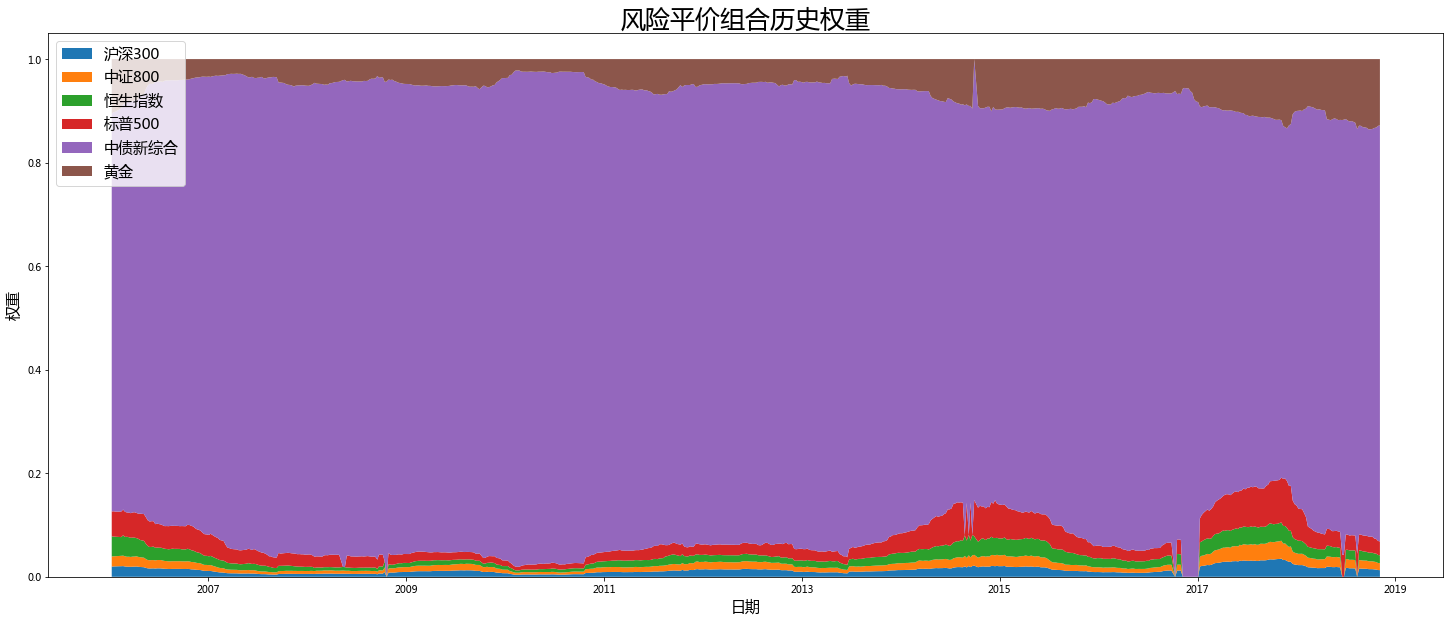

In [93]:
fig, ax = plt.subplots(figsize=(25, 10))
_ = ax.stackplot(weight_plot.index, 
                 weight_plot['000300.SH'],
                 weight_plot['000906.SH'],
                 weight_plot['HSI.HI'],
                 weight_plot['SPX.GI'],
                 weight_plot['CBA00101.CS'],
                 weight_plot['AU9999.SGE'], 
                 labels=[u'沪深300', u'中证800', u'恒生指数', u'标普500', u'中债新综合', u'黄金'])
ax.legend(loc='upper left', fontsize=15)
ax.set_title(u'风险平价组合历史权重', fontsize=25)
ax.set_ylabel(u'权重', fontsize=15)
ax.set_xlabel(u'日期', fontsize=15)
fig.savefig('../pic/portfolio_weight.jpg', dpi=200, bbox_inches='tight')

In [94]:
metric(portfolio_ret)

Annual return: 4.87%
Sharpe ratio: 2.58
Annual volatility: 1.85%
Max drawdown: -3.53%


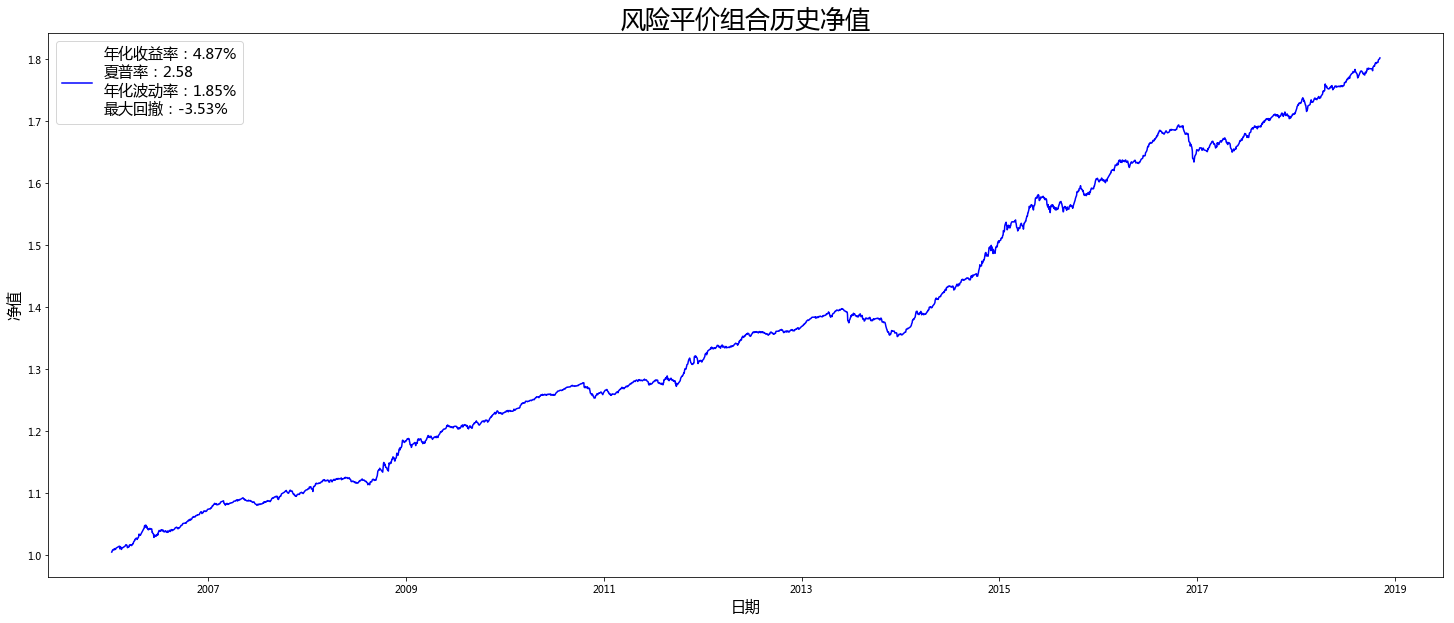

In [95]:
fig, ax = plt.subplots(figsize=(25, 10))
ax.plot((1 + portfolio_ret).cumprod(), color='blue',
       label=u'年化收益率：4.87%\n夏普率：2.58\n年化波动率：1.85%\n最大回撤：-3.53%')
ax.set_title(u'风险平价组合历史净值', fontsize=25)
ax.set_ylabel(u'净值', fontsize=15)
ax.set_xlabel(u'日期', fontsize=15)
ax.legend(loc='upper left', fontsize=15)
fig.savefig('../pic/portfolio_return.jpg', dpi=200, bbox_inches='tight')

# 今年以来风险平价组合与各类资产情况

In [96]:
fname = u'../data/stats.xlsx'

In [97]:
workbook = xlsxwriter.Workbook(fname)
worksheet = workbook.add_worksheet()

In [98]:
col_format = workbook.add_format({'bold': True, 'align': 'center', 'font_name': u'楷体', 'font_color': '#FFFFFF', 'bg_color': '#993333'})
cell_format = workbook.add_format({'font_name': u'楷体'})
percent_format = workbook.add_format({'font_name': u'楷体', 'num_format': '0.00%'})
number_format = workbook.add_format({'font_name': u'楷体', 'num_format': '0.00'})

In [99]:
worksheet.write('A1', '', col_format)
worksheet.write('B1', u'收益率(周)', col_format)
worksheet.write('C1', u'收益率(月)', col_format)
worksheet.write('D1', u'收益率(年)', col_format)
worksheet.write('E1', u'波动率(年)', col_format)
worksheet.write('F1', u'夏普率(年)', col_format)
worksheet.write('G1', u'当前权重', col_format)
worksheet.write('H1', u'风险贡献', col_format)

0

In [100]:
weights = weight.iloc[-1]

In [101]:
worksheet.write('A2', u'沪深300', cell_format)
s = ret_df[ret_df.index >= '2018-01-01']['000300.SH']
retw = empyrical.cum_returns_final(s[-5:])
retm = empyrical.cum_returns_final(s[-20:])
ret = empyrical.cum_returns_final(s)
vol = empyrical.annual_volatility(s)
sh = empyrical.sharpe_ratio(s)
w = weights['000300.SH']
rc = assets_risk_budget[0]
worksheet.write('B2', retw, percent_format)
worksheet.write('C2', retm, percent_format)
worksheet.write('D2', ret, percent_format)
worksheet.write('E2', vol, percent_format)
worksheet.write('F2', sh, number_format)
worksheet.write('G2', w, percent_format)
worksheet.write('H2', rc, percent_format)

0

In [102]:
worksheet.write('A3', u'中证800', cell_format)
s = ret_df[ret_df.index >= '2018-01-01']['000906.SH']
retw = empyrical.cum_returns_final(s[-5:])
retm = empyrical.cum_returns_final(s[-20:])
ret = empyrical.cum_returns_final(s)
vol = empyrical.annual_volatility(s)
sh = empyrical.sharpe_ratio(s)
w = weights['000906.SH']
rc = assets_risk_budget[1]
worksheet.write('B3', retw, percent_format)
worksheet.write('C3', retm, percent_format)
worksheet.write('D3', ret, percent_format)
worksheet.write('E3', vol, percent_format)
worksheet.write('F3', sh, number_format)
worksheet.write('G3', w, percent_format)
worksheet.write('H3', rc, percent_format)

0

In [103]:
worksheet.write('A4', u'恒生指数', cell_format)
s = ret_df[ret_df.index >= '2018-01-01']['HSI.HI']
retw = empyrical.cum_returns_final(s[-5:])
retm = empyrical.cum_returns_final(s[-20:])
ret = empyrical.cum_returns_final(s)
vol = empyrical.annual_volatility(s)
sh = empyrical.sharpe_ratio(s)
w = weights['HSI.HI']
rc = assets_risk_budget[2]
worksheet.write('B4', retw, percent_format)
worksheet.write('C4', retm, percent_format)
worksheet.write('D4', ret, percent_format)
worksheet.write('E4', vol, percent_format)
worksheet.write('F4', sh, number_format)
worksheet.write('G4', w, percent_format)
worksheet.write('H4', rc, percent_format)

0

In [104]:
worksheet.write('A5', u'标普500', cell_format)
s = ret_df[ret_df.index >= '2018-01-01']['SPX.GI']
retw = empyrical.cum_returns_final(s[-5:])
retm = empyrical.cum_returns_final(s[-20:])
ret = empyrical.cum_returns_final(s)
vol = empyrical.annual_volatility(s)
sh = empyrical.sharpe_ratio(s)
w = weights['SPX.GI']
rc = assets_risk_budget[3]
worksheet.write('B5', retw, percent_format)
worksheet.write('C5', retm, percent_format)
worksheet.write('D5', ret, percent_format)
worksheet.write('E5', vol, percent_format)
worksheet.write('F5', sh, number_format)
worksheet.write('G5', w, percent_format)
worksheet.write('H5', rc, percent_format)

0

In [105]:
worksheet.write('A6', u'中债新综合', cell_format)
s = ret_df[ret_df.index >= '2018-01-01']['CBA00101.CS']
retw = empyrical.cum_returns_final(s[-5:])
retm = empyrical.cum_returns_final(s[-20:])
ret = empyrical.cum_returns_final(s)
vol = empyrical.annual_volatility(s)
sh = empyrical.sharpe_ratio(s)
w = weights['CBA00101.CS']
rc = assets_risk_budget[4]
worksheet.write('B6', retw, percent_format)
worksheet.write('C6', retm, percent_format)
worksheet.write('D6', ret, percent_format)
worksheet.write('E6', vol, percent_format)
worksheet.write('F6', sh, number_format)
worksheet.write('G6', w, percent_format)
worksheet.write('H6', rc, percent_format)

0

In [106]:
worksheet.write('A7', u'黄金', cell_format)
s = ret_df[ret_df.index >= '2018-01-01']['AU9999.SGE']
retw = empyrical.cum_returns_final(s[-5:])
retm = empyrical.cum_returns_final(s[-20:])
ret = empyrical.cum_returns_final(s)
vol = empyrical.annual_volatility(s)
sh = empyrical.sharpe_ratio(s)
w = weights['AU9999.SGE']
rc = assets_risk_budget[5]
worksheet.write('B7', retw, percent_format)
worksheet.write('C7', retm, percent_format)
worksheet.write('D7', ret, percent_format)
worksheet.write('E7', vol, percent_format)
worksheet.write('F7', sh, number_format)
worksheet.write('G7', w, percent_format)
worksheet.write('H7', rc, percent_format)

0

In [107]:
worksheet.write('A8', u'现金', cell_format)
s = odf[odf.index >= '2018-01-01']['H11025.CSI'].pct_change()
retw = empyrical.cum_returns_final(s[-5:])
retm = empyrical.cum_returns_final(s[-20:])
ret = empyrical.cum_returns_final(s)
vol = empyrical.annual_volatility(s)
sh = empyrical.sharpe_ratio(s)
worksheet.write('B8', retw, percent_format)
worksheet.write('C8', retm, percent_format)
worksheet.write('D8', ret, percent_format)
worksheet.write('E8', vol, percent_format)
worksheet.write('F8', sh, number_format)
worksheet.write('G8', 0, percent_format)
worksheet.write('H8', 0, percent_format)

0

In [108]:
worksheet.write('A9', u'风险平价组合', cell_format)
s = portfolio_ret[portfolio_ret.index >= '2018-01-01']
retw = empyrical.cum_returns_final(s[-5:])
retm = empyrical.cum_returns_final(s[-20:])
ret = empyrical.cum_returns_final(s)
vol = empyrical.annual_volatility(s)
sh = empyrical.sharpe_ratio(s)
worksheet.write('B9', retw, percent_format)
worksheet.write('C9', retm, percent_format)
worksheet.write('D9', ret, percent_format)
worksheet.write('E9', vol, percent_format)
worksheet.write('F9', sh, number_format)
worksheet.write('G9', 1, percent_format)
worksheet.write('H9', 1, percent_format)

0

In [109]:
worksheet.set_column(0, 0, 15)

0

In [110]:
workbook.close()